# Problem 1

## (a) Numerical Differentiation

The forward difference formulas for the first and second derivatives come from the Taylor expansion for $f(x+h)$:

$$f(x+h) = f(x) + hf'(x) + \frac{h^2}{2!} f''(x) + \frac{h^3}{3!} f'''(x) + \dots$$

By solving for $f'(x)$, we find

$$f'_\text{fd}(x) = \frac{f(x+h) - f(x)}{h}$$

To find a forward difference formula for $f''(x)$, first calculate 

$$f(x+2h) = f(x) + 2hf'(x) + \frac{4h^2}{2!} f''(x) + \frac{8h^3}{3!} f'''(x) + \dots$$

Then combine expressions to solve for $f''(x)$:

$$f''_\text{fd}(x) = \frac{f(x) - 2f(x+h) + f(x+2h)}{h^2} + \mathcal{O}(h)$$

Note that the error here is $\mathcal{O}(h)$ because the $f'''$ terms have not cancelled.

The central difference formula for the second derivative is just the "midpoint" algorithm you derived in HW #1:

$$f''_\text{cd}(x) = \frac{f(x+h)-2f(x) + f(x-h)}{h^2} + \mathcal{O}(h^2)$$


In [2]:
import numpy as np

def f(x):
    return x*np.exp(x)

def second_derivative_fd(f, x, h):
    return (f(x) - 2*f(x+h) + f(x+2*h))/pow(h,2)

def second_derivative_cd(f, x, h):
    return (f(x+h) - 2*f(x) + f(x-h))/pow(h,2)

x = 2.0
h_values = []
forward_difference_approximations = []
central_difference_approximations = []
print("h \t Forward Diff \t Central Diff")
for h in np.arange(0.50, 0.00, -0.05):
    print("%.2f \t %.5f \t %.5f" % (h, second_derivative_fd(f, x, h), second_derivative_cd(f, x, h)))
    h_values.append(h)
    forward_difference_approximations.append(second_derivative_fd(f, x, h))
    central_difference_approximations.append(second_derivative_cd(f, x, h))

h 	 Forward Diff 	 Central Diff
0.50 	 56.48901 	 30.49018
0.45 	 52.84067 	 30.31113
0.40 	 49.44923 	 30.15157
0.35 	 46.29559 	 30.01127
0.30 	 43.36213 	 29.89006
0.25 	 40.63257 	 29.78777
0.20 	 38.09190 	 29.70427
0.15 	 35.72625 	 29.63943
0.10 	 33.52283 	 29.59319
0.05 	 31.46979 	 29.56546


## (b) Verifying the Error

The error is calculated by comparing the numerical result with the exact derivative

$$
\begin{align}
f(x) &= x e^x \\
f'(x) &= e^x + x e^x \\
f''(x) &= e^x + e^x + x e^x \\
f''(2) & = 4 e^2
\end{align}
$$

In [3]:
import matplotlib.pyplot as plt

exact_answer = 4 * np.exp(2)
print("Exact derivative is", exact_answer)

forward_difference_absolute_errors = []
central_difference_absolute_errors = []
for fd_approximation in forward_difference_approximations:
    forward_difference_absolute_errors.append(fd_approximation - exact_answer)

for cd_approximation in central_difference_approximations:
    central_difference_absolute_errors.append(cd_approximation - exact_answer)
    
fig = plt.figure(1)
fig1 = fig.add_subplot(2,1,1)
fig1.plot(np.log(h_values), np.log(forward_difference_absolute_errors))
fig1.set_ylabel('log(forward diff error)')
fig2 = fig.add_subplot(2,1,2)
fig2.plot(np.log(h_values), np.log(central_difference_absolute_errors))
fig2.set_xlabel('log(h)')
fig2.set_ylabel('log(central diff error)')
plt.show()
print("Results of 1-d fits (slope, intercept):")
print("For FD:", np.polyfit(np.log(h_values), np.log(forward_difference_absolute_errors),1))
print("For CD:", np.polyfit(np.log(h_values), np.log(central_difference_absolute_errors),1))

Exact derivative is 29.5562243957226


<Figure size 640x480 with 2 Axes>

Results of 1-d fits (slope, intercept):
For FD: [1.14844367 4.0327738 ]
For CD: [2.00447419 1.31777614]


The slope of the log-log plot gives us the exponent of the $h$ dependence. For example, if the plot has a slope of 2: 
$$\log \epsilon = 2 \log h = \log h^2 ,$$
and therefore $\epsilon \sim h^2$.

The fits show that the dependence of the errors is roughly $\mathcal{O}(h^{1.1})$ for forward difference and almost exactly $\mathcal{O}(h^2)$ for central difference.  This is just as expected from the derivation.  (1.1 should actually be 1.0 for the forward difference algorithm.)

# Problem 2



## (a) Plotting the distribution

We use the given values $M=90$ and $\Gamma=10$.  We will use these fixed values in the definition of the Breit-Wigner function.

In [4]:
def bw(E):
    M = 90.0
    Gamma = 10.0
    g = np.sqrt(M*M*(M*M+Gamma+Gamma))
    k = 2.*np.sqrt(2)*M*Gamma*g/np.pi/np.sqrt(M*M+g)
    return k/((E*E-M*M)*(E*E-M*M)+M*M*Gamma*Gamma)

The number of points in the plot is arbitrary, so I will start with 10,000 points.

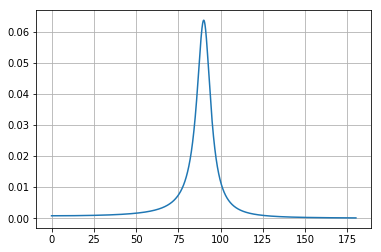

In [5]:
import numpy as np
import scipy.misc
import matplotlib.pyplot as plt
E_values = np.linspace(0.,180.,10000)
bw_values = bw(E_values)
plt.plot(E_values, bw_values)
plt.grid()
plt.show()

If you look very carefully, you can see that the function is not completely symmetric.  The low-side tail is higher than the high-side tail.

## (b) Numerical integration with trapezoidal rule

The `trap` function below performs the integration for a list of $(x,y)$ values.
The output here uses the `E_values` and `bw_values` from part (a).

In [6]:
def trap(x_val, y_val): 
    
    area_total = 0 # a running record of the area I have integrated so far
    
    h = (x_val[-1] - x_val[0]) / (len(x_val) - 1) # the distance between adjacent points 
    
    # loop through index values
    # I need to start at the first point, but only run to the penultimate point 
    for i in range(len(x_val) - 1):
        
        # determine the area of one of my trapezoids
        first_y = y_val[i]
        second_y = y_val[i + 1]
        area = 0.5 * h * (first_y + second_y)
        
        # add this area to my running total 
        area_total += area
        
    return area_total

In [7]:
my_result = trap(E_values, bw_values)
numpy_result = np.trapz(bw_values, E_values) 
print ("My calculated area is %.16f" % my_result)
print ("Numpy's calculated area is %.16f" % numpy_result)

My calculated area is 0.9921802591423964
Numpy's calculated area is 0.9921802591423923


## (c) Numerical integration with Simpson's rule

This integration uses Simpson's rule, with an odd number of data points.
The `simpson` function performs the integration for a list of (x,y) values.
We have to remove one point from `x_val` and `y_val` to get the odd number of data points; otherwise we would trigger the error message and get `None` for the result.  (Try it by redefining `x_odd`.)

In [29]:

# I remove the last data point from my lists
# Negative indexing is something not found in every language, 
# but it is useful to be familiar with. 
x_odd = E_values[0:-1]
y_odd = bw_values[0:-1]

def simpson(x_val, y_val):
    weights = []
    
    # check if my x values are even
    # the '%' here represents the modulo operation, or the remainder
    # after division. 
    if len(x_val)%2 == 0:
        print ('Simpson\'s rule requires an odd number of points, but you have supplied an even number.')
        return
    
    # An else statement would also work, but you should try and anticipate 
    # different outcomes as much as possible. 
    elif len(x_val)%2 == 1:
        
        h = (x_val[-1] - x_val[0]) / (len(x_val) - 1) # distance between points 
        
        # I employ indexing tricks somewhat unique to python. 
        weights = np.empty(len(x_val))
        weights[::2] = (2/3) * h
        weights[1::2] = (4/3) * h
        weights[0] = h/3
        weights[-1] = h/3
        
        return np.sum(weights * np.array(y_val))

In [30]:
from scipy.integrate import simps

my_result = simpson(x_odd, y_odd)
numpy_result = simps(y_odd, x_odd)

print ("My calculated area is %.8f" % my_result)
print ("Scipy's calculated area is %.8f" % numpy_result)

My calculated area is 0.99217869
Scipy's calculated area is 0.99217869


The results from the trapezoidal rule and Simpson's rule are slightly different.  This is expected because the second derivative of the function is not zero.

## (d) Calculating the fraction

We need to calculate the following fraction:
$$\frac{\int_{60}^{120} f(E) dE} 
{\int_{0}^{180} f(E) dE}$$

The simplest approach is to use the `trap` function we wrote to integrate a generic list of $(x,y)$ values.

In [37]:
full_E_values = np.linspace(0., 180., 10000)
full_bw_values = bw(full_E_values)

restricted_E_values = np.linspace(60., 120., 10000)
restricted_bw_values = bw(restricted_E_values)

In [40]:
full_integral = trap(full_E_values, full_bw_values)
restricted_integral = trap(restricted_E_values, restricted_bw_values)

print("ratio of integrals is %f" % (restricted_integral/full_integral))

ratio of integrals is 0.907903


# Problem 3

We will use Romberg integration to calculate

$$\int_0^{\pi/2} \frac{d\theta}{1+\cos\theta}$$

to 8 decimal places of accuracy.  This corresponds to an absolute error of less than `5e-9`.

The trickiest part about writing the code is setting up the triangular array of results.  The array is built in the following order:

$$
\begin{array}{ccc}
0 & & \\
1 & 2 & \\
3 & 4 & 5 \\
\end{array}
$$


In [8]:
from numpy import *
from scipy import integrate

def f(theta):
    return 1.0/(1.0+cos(theta))

# Weights for trapezoid rule
# i: index value of weight [1,N]
# h: interval width
# N: number of intervals
def wTrap(i, h, N):
    if (i == 1 or i == N):
        wLocal = h/2.0
    else:
        wLocal = h
    return wLocal

# Integration with the Trapezoid rule
# f: integrand function
# a: lower limit of integration
# b: upper limit of integration
# N: number of points
def integrate_trapezoid(f, a, b, N):
    sum = 0.0
    h = (b - a)/(N - 1)
    for i in range(1, N+1):
        x = a + (i -1) * h
        sum = sum + wTrap(i, h, N) * f(x)
#    print(sum)
    return sum

# T is the triangular array of Romberg results
# It is really a list of lists, but we access it like an array
T = []
for m in range(10):
    entries_in_row = []
    for k in range(m+1):
        entries_in_row.append(0.)
    T.append(entries_in_row)

current_precision = 1.0
for m in range(10):
    for k in range(m+1):
        # N is number of intervals, not points
        N = pow(2,m)
        if k == 0:
            # The integration function needs number of points, not intervals
            T[m][k] = integrate_trapezoid(f, 0.0, pi/2., N+1)
        else:
            # This is the recursion relation presented in Lecture 4
            T[m][k] = (pow(4.,k)*T[m][k-1] - T[m-1][k-1])/(pow(4.,k)-1.)
    if (m>0):
        current_precision = T[m][k] - T[m-1][k-1]
    last_result = T[m][k]
    print("Last result is %.20f" % last_result)
    print("Current precision is ", abs(current_precision))
    if (abs(current_precision)<1e-08):
        break

# Uncomment this block to see the triangular array
for row in T:
    print(row)
    
print("Just for fun, here is the result from the Python scipy.integrate.romberg function:")
print("%.8f" % integrate.romberg(f, 0.0, pi/2., tol=1.e-10, show=True))

Last result is 1.17809724509617241850
Current precision is  1.0
Last result is 1.00613320470579759025
Current precision is  0.17196404039037483
Last result is 1.00017660797390073313
Current precision is  0.005956596731896857
Last result is 1.00000245923435859829
Current precision is  0.00017414873954213483
Last result is 1.00000001385299674972
Current precision is  2.4453813618485754e-06
Last result is 1.00000000002871392013
Current precision is  1.3824282829588697e-08
Last result is 1.00000000000002087219
Current precision is  2.8693047937622396e-11
[1.1780972450961724]
[1.0491242148033912, 1.0061332047057976]
[1.0126927251530808, 1.0005488952696442, 1.0001766079739007]
[1.0032025531583884, 1.0000391624934908, 1.000005180308414, 1.0000024592343586]
[1.0008025471437383, 1.000002545138855, 1.0000001039818793, 1.0000000234052677, 1.0000000138529967]
[1.0002007573240816, 1.0000001607175293, 1.0000000017561075, 1.0000000001334761, 1.0000000000422142, 1.000000000028714]
[1.000050196884356, 

Our answer after the final iteration is 1.00000000000002087219.  The accuracy is quite a bit better than $10^{-8}$, but that's because the previous iteration was not quite good enough.

The exact answer is indeed $\int_0^{\pi/2} \frac{d\theta}{1+\cos\theta}=1$.

# Problem 4

## (a) Intensity as function of $v$

Note that $v$ is the limit of integration and **not** the variable of integration.
There do not seem to be any singularities present in these integrals, so we will do this integration with a simple trapezoidal rule algorithm.  The only question is what to use for the number of intervals $N$.  I found that $N=1000$ already gives an accuracy better than 0.1%.

In [9]:
def fcos(w):
    return cos(pi*pow(w,2)/2)

def fsin(w):
    return sin(pi*pow(w,2)/2)

def wTrap(i, h):
    if ( (i == 1) or (i == N) ):
        wLocal = h/2.0
    else:
        wLocal = h
    return wLocal

def integrate_trapezoidal(f, a, b, N):
    h = (b - a)/(N - 1)
    sum = 0.0
    for i in range(1, N + 1):
        x = a + (i - 1)*h
        w = wTrap(i, h)
        sum  = sum + w * f(x)
    return sum

v_values = []
intensity_values = []
for v in arange(0.0, 10.0, 0.01):
    c = integrate_trapezoidal(fcos, 0.0, v, 1000)
    s = integrate_trapezoidal(fsin, 0.0, v, 1000)
    intensity_ratio = 0.5*(pow(c+0.5,2) + pow(s+0.5,2))
    if v <= 0.05 or v >= 9.95:
        print(v, intensity_ratio)
    elif v == 1: 
        print('...')
    v_values.append(v)
    intensity_values.append(intensity_ratio)


0.0 0.25
0.01 0.255050262179
0.02 0.260202097126
0.03 0.265457076072
0.04 0.270816767105
0.05 0.276282733478
...
9.95 0.957012541828
9.96 0.950619146481
9.97 0.948409993321
9.98 0.95060354602
9.99 0.956989000731


## (b) Plotting the intensity ratio $I/I_0$

The $x$ range is arbitrary.  There needs to be enough range to see the oscillations and the asymptotic approach to $I=I_0$.

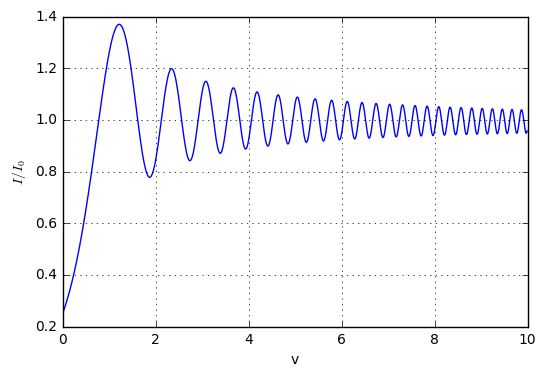

In [10]:
plt.plot(v_values, intensity_values)
plt.xlabel("v")
plt.ylabel("$I/I_0$")
plt.grid()
plt.show()

# Problem 5

In this derivation, $\theta$ is the variable coordinate, and $\theta_m$ is the maximum value it attains.

## (a) Derivation

The energy $E = \frac{1}{2} m \left(l \dot\theta \right)^2 + mgl (1-\cos\theta)$ is conserved.
Using energy conservation is important, but not completely sufficient for the derivation.

At $\theta=0$, we know $E(\theta=0) = \frac{1}{2} m\left(l \dot\theta \right)^2$.

At $\theta=\theta_m$, where $\dot\theta=0$, we know $E(\theta=\theta_m) = mgl (1-\cos\theta_m)$.

Equating the two expressions for $E$ gives

$$\begin{align}
\frac{1}{2}ml^2 \left[ \dot\theta(0) \right]^2 &= mgl(1-\cos\theta_m) \\
\left[ \dot\theta(0) \right]^2 &= \frac{2g}{l} (1-\cos\theta_m)
\end{align}$$

We cannot simply integrate this expression for $\dot\theta$ to find $\theta$ because the expression is only correct for $\theta=0$.

Instead, we return to the original equation of motion:
$$\ddot\theta = -\frac{g}{l}\sin\theta$$

In order to integrate this expression, we first multiply both sides by $\dot\theta$.  Then we can integrate as follows:

$$\begin{align}
\int \ddot\theta \dot\theta\ dt &= \int \frac{-g}{l} \sin\theta \dot\theta \ dt \\
\frac{1}{2} {\dot\theta}^2 &= \frac{g}{l} \cos\theta + C \\
\left[ \dot\theta \right]^2 &= \frac{2g}{l} \cos\theta + C
\end{align}$$

To find $C$, we use the known value of $\dot\theta(\theta=0)$:
$$\begin{align}
\left[ \dot\theta(\theta=0) \right]^2 &= \frac{2g}{l} + C \\
\frac{2g}{l} (1-\cos\theta_m) &= \frac{2g}{l} + C \\
\frac{-2g}{l} \cos\theta_m &= C
\end{align}$$
where we have inserted the known value from above.

With this constant, we can summarize $\dot\theta$:
$$\begin{align}
\dot\theta (\theta) &= \sqrt{\frac{2g}{l} (\cos\theta - \cos\theta_m)} \\
&= \frac{2\pi\sqrt{2}}{T_0} \sqrt{(\cos\theta - \cos\theta_m)}
\end{align}$$

Now that we have the expression for $\dot\theta$ for all $\theta$, we can integrate to find the time for the pendulum to swing from $\theta=0$ to $\theta=\theta_m$.  This should be a quarter of the total period.

$$\begin{align}
\frac{1}{4} T &= \int_{t_1}^{t_2} \dot\theta dt \\
\frac{1}{4} \frac{T(\theta_m)}{T_0} &= \frac{1}{2\pi\sqrt{2}} \int_0^{\theta_m} \frac{d\theta}{\sqrt{\cos\theta - \cos\theta_m}} \\
\frac{T(\theta_m)}{T_0} &= \frac{\sqrt{2}}{\pi} \int_0^{\theta_m} \frac{d\theta}{\sqrt{\cos\theta - \cos\theta_m}}
\end{align}$$

## (b) Recasting the Integral

We start with the result from part (a) and make the substitutions $\cos\theta = 1-2\sin^2(\theta/2)$ and then $\sin(\theta/2) = \sin\psi \sin(\theta_m/2)$:

$$
\begin{align}
\frac{\sqrt{2}}{\pi} \int_0^{\theta_m} \frac{d\theta}{\sqrt{\cos\theta - \cos\theta_m}} &=
\frac{\sqrt{2}}{\pi} \int_0^{\theta_m} \frac{d\theta}{\sqrt{-2\sin^2(\theta/2) + 2\sin^2(\theta_m/2)}}\\
&= \frac{\sqrt{2}}{\pi} \int_0^{\theta_m} \frac{d\theta}{\sqrt{2\sin^2(\theta_m/2) - 2\sin^2(\theta_m/2)\sin^2\psi}} \\
\end{align}
$$

The second substitution helps us change variables from $\theta$ to $\psi$:

$$
\begin{align}
\frac{d}{d\psi} \left[\sin(\theta_m/2) \sin\psi \right] &= \frac{d}{d\psi} sin(\theta/2) \\
\sin(\theta_m/2) \cos\psi &= \cos(\theta/2) \frac{1}{2} \frac{d\theta}{d\psi} \\
2 \sin(\theta_m/2) \cos\psi \ d\psi &= d\theta \\
\end{align}
$$

All that remains is to simplify:
$$\begin{align}
\frac{\sqrt{2}}{\pi} \int_0^{\theta_m} \frac{d\theta}{\sqrt{2\sin^2(\theta_m/2) - 2\sin^2(\theta_m/2)\sin^2\psi}} &= \frac{\sqrt{2}}{\pi} \int_0^{\pi/2} \frac{2\sin(\theta_m/2)\cos\psi\ d\psi}{\cos(\theta/2) \sqrt{2\sin^2(\theta_m/2)(1-\sin^2\psi)}} \\
&= \frac{\sqrt{2}}{\pi} \int_0^{\pi/2} \frac{\sqrt{2} \cos\psi\ d\psi}{\cos(\theta/2) \sqrt{1-\sin^2\psi}} \\
&= \frac{2}{\pi} \int_0^{\pi/2} \frac{d\psi}{\cos(\theta/2)} \\
&= \frac{2}{\pi} \int_0^{\pi/2} \frac{d\psi}{\sqrt{1-\sin^2(\theta/2)}} \\
\frac{T(\theta_m)}{T_0} &= \frac{2}{\pi} \int_0^{\pi/2} \frac{d\psi}{\sqrt{1-\sin^2(\theta_m/2)\sin^2\psi}}
\end{align}$$


## (c) Numerical Evaluation

There are no singularities in this integrand, as long as we do not consider the extreme case of $\theta_m = \pi$.  Therefore, we can perform a simple integration with Simpson's rule.  I use a rather large number for $N$ because it does not take long.

In [11]:
def f(psi, theta_m):
    denominator = sqrt(1 - pow(sin(theta_m/2.),2) * pow(sin(psi),2))
    return 1./denominator

def wSimpson(i, h):                            
    if ( (i == 1) or (i == N) ):
        wTotal = h/3.0
    elif (i%2 == 0):
        # Even i
        wTotal = 4.*h/3.0
    else:
        # Odd i
        wTotal = 2.*h/3.0
    return wTotal

def integrate_simpson(f, theta_m, a, b, N):
    # N is number of points, not intervals.  It must be odd.
    if (N%2 == 0):
        N += 1
    h = (b - a)/(N - 1)
    sum = 0.0
    for i in range(1, N + 1):
        psi = a + (i - 1)*h
        w = wSimpson(i, h)
        sum  = sum + w * f(psi, theta_m)
    return sum

for theta_m in (0.1, 0.2, pi/4., pi/2., 3.*pi/4.):
    integral = integrate_simpson(f, theta_m, 0.0, pi/2., 1000)
    print("For theta_m = %.3f, T/T_0 = %.3f" % (theta_m, 2./pi * integral))


For theta_m = 0.100, T/T_0 = 1.000
For theta_m = 0.200, T/T_0 = 1.002
For theta_m = 0.785, T/T_0 = 1.039
For theta_m = 1.571, T/T_0 = 1.180
For theta_m = 2.356, T/T_0 = 1.528


## (d) Limits of Small-angle Approximation

We can see that $\theta_m > \pi/4$ results in a period more than 1% different from $T_0$, the result from the small-angle approximation.  But where is the threshold where the variation is exactly 1%?

To find this, we scan the value of `theta_m` and recalculate $T/T_0$.

In [12]:
for theta_m in arange(0.2, pi/4., 0.05):
    integral = integrate_simpson(f, theta_m, 0.0, pi/2., 1000)
    print("For theta_m = %.3f, T/T_0 = %.5f" % (theta_m, 2./pi * integral))

For theta_m = 0.200, T/T_0 = 1.00184
For theta_m = 0.250, T/T_0 = 1.00326
For theta_m = 0.300, T/T_0 = 1.00499
For theta_m = 0.350, T/T_0 = 1.00705
For theta_m = 0.400, T/T_0 = 1.00943
For theta_m = 0.450, T/T_0 = 1.01215
For theta_m = 0.500, T/T_0 = 1.01520
For theta_m = 0.550, T/T_0 = 1.01859
For theta_m = 0.600, T/T_0 = 1.02232
For theta_m = 0.650, T/T_0 = 1.02641
For theta_m = 0.700, T/T_0 = 1.03087
For theta_m = 0.750, T/T_0 = 1.03569


The amplitude differs by more than 1% from $T_0$ when $\theta_m > 0.40$.